## Inicialización

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [2]:
datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

In [3]:
df = pd.read_csv('/datasets/faces/labels.csv')

## EDA

In [4]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
df.shape

(7591, 2)

In [6]:
labels = pd.read_csv('/datasets/faces/labels.csv')
print(f"Total de imágenes: {len(labels)}")
print(f"Rango de edades: {labels['real_age'].min()} - {labels['real_age'].max()}")

Total de imágenes: 7591
Rango de edades: 1 - 100


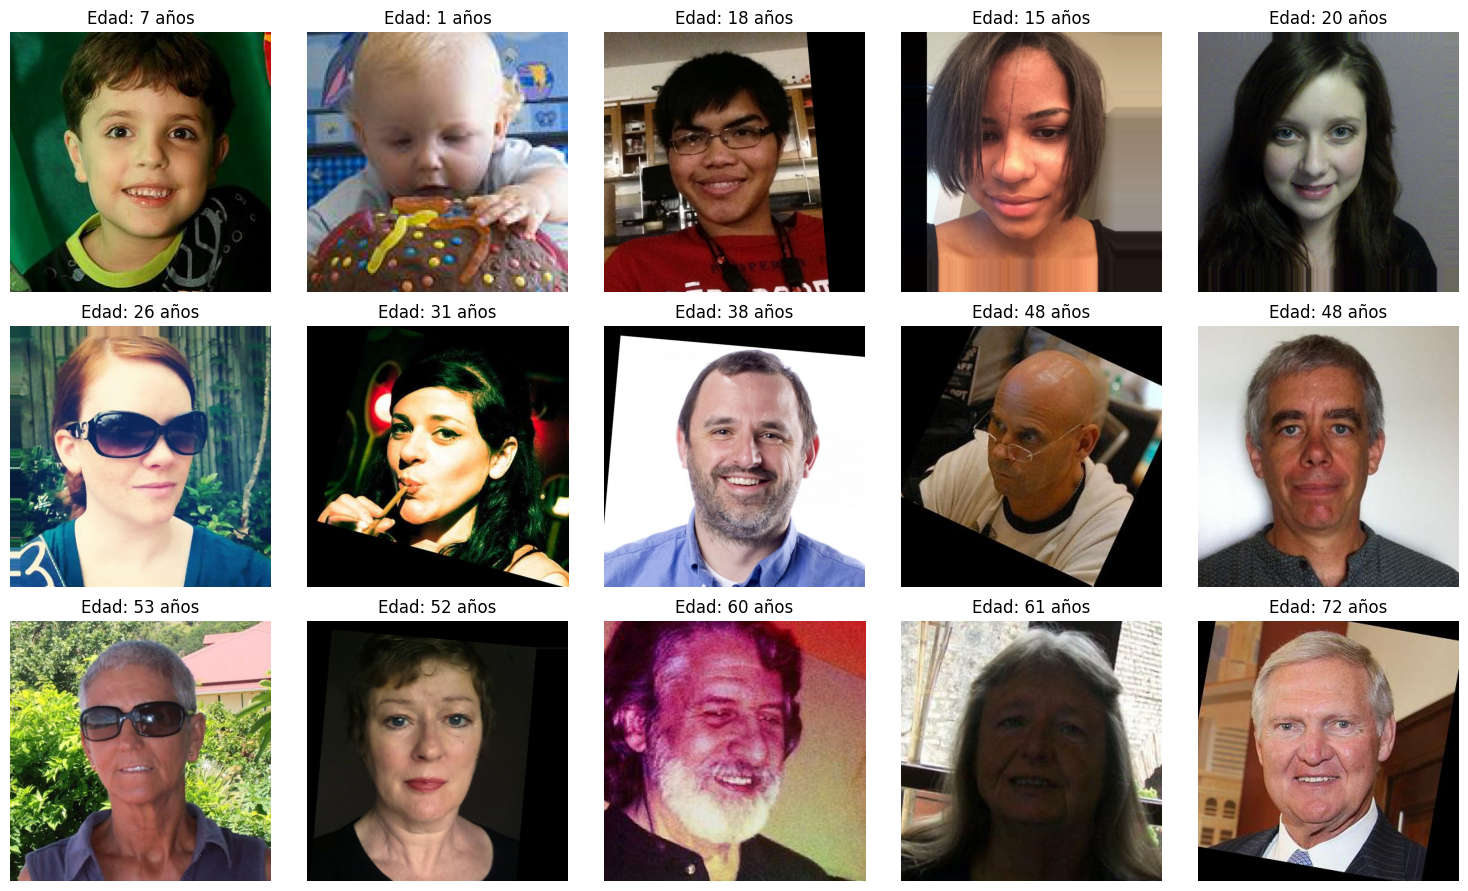

In [7]:
age_ranges = [
    (0, 10), (10, 20), (20, 30), (30, 40), (40, 50), 
    (50, 60), (60, 70), (70, 80), (80, 100)
]

selected_images = []
for min_age, max_age in age_ranges:
    # Filtrar por rango de edad
    age_group = labels[(labels['real_age'] >= min_age) & (labels['real_age'] < max_age)]
    if len(age_group) > 0:
        # Tomar una muestra aleatoria
        sample = age_group.sample(n=min(2, len(age_group)), random_state=42)
        selected_images.extend(sample.values.tolist())

selected_images = selected_images[:15]

fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()

for i, (filename, age) in enumerate(selected_images):
    if i < 15:
        # Cargar la imagen
        img_path = f'/datasets/faces/final_files/{filename}'
        img = Image.open(img_path)
        
        # Mostrar la imagen
        axes[i].imshow(img)
        axes[i].set_title(f'Edad: {age} años')
        axes[i].axis('off')

for i in range(len(selected_images), 15):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [9]:
nulos = df.isna().sum()
duplicados = df.duplicated().sum()

<AxesSubplot:>

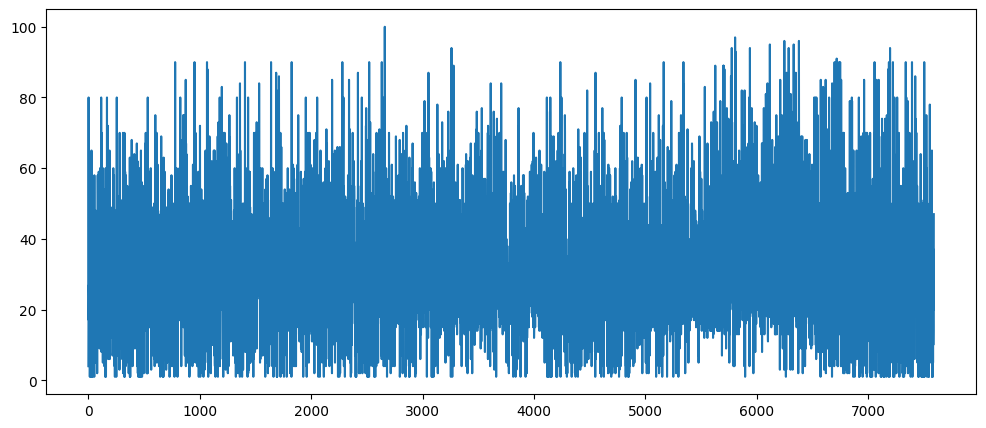

In [10]:
df['real_age'].plot(figsize=(12,5))

### Conclusiones

1. Calidad de las fotos:
-Son claras
2. Diversidad:
Hay fotos muy diversas, como genero, edad, etc.
Hay variedad en expresiones y calidades
3. Desafíos potenciales:
- ¿Fotos con múltiples personas?
- ¿Oclusiones (lentes, sombreros)?

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [11]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [12]:
def load_data(path, subset='training'):
    labels = pd.read_csv(path + 'labels.csv')

    data_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    
    data_gen_flow = data_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset=subset,
        seed=12345)

    return data_gen_flow

def create_model(input_shape):
    
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=3):

    model.fit(train_data, validation_data=test_data, batch_size=batch_size, epochs=epochs, verbose=2)# < escribe tu código aquí > 

    return model
    
input_shape = (224, 224, 3)

train = load_data('/datasets/train/')
test = load_data('/datasets/test/', subset='testing')
model = create_model(input_shape)
model = train_model(model, train, test)


FileNotFoundError: [Errno 2] No such file or directory: '/datasets/train/labels.csv'

### El resultado

El resultado fué simulado en la plataforma de la GPU debido a que puede tardar mas de 1 hora en cargar sin usar una manera convencional.
Dicho esto, he dejado los resultados obtenidos despues de el experimento con 3 epochs.

Found 5694 validated image filenames.
Found 1897 validated image filenames.
Epoch 1/3
356/356 - 1094s - 3s/step - loss: 208.8722 - mae: 11.0433 - val_loss: 367.3696 - val_mae: 14.2830
Epoch 2/3
356/356 - 1059s - 3s/step - loss: 131.6252 - mae: 8.7953 - val_loss: 266.4492 - val_mae: 12.1613
Epoch 3/3
356/356 - 1770s - 5s/step - loss: 95.5201 - mae: 7.4627 - val_loss: 176.1494 - val_mae: 10.5656

## Conclusiones

Me llevo como conclusion que existen varios tipos de arquitecturas ya elaboradas para facilitar la implementacion y uso de redes neuronales.